# Multivariate_CNN

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn import preprocessing
from tensorflow.keras import regularizers

In [2]:
# fix tensorflow gpu problems
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession
config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

In [3]:
# check gpu support
gpus = tf.config.list_physical_devices('GPU')
print(len(gpus))
print(tf.test.is_built_with_gpu_support())
print(tf.test.is_built_with_cuda())
print(tf.test.gpu_device_name())

0
True
True



## 1. Load the dataset

In [4]:
df = pd.read_csv('Lumos5G-v1.0.csv',
                index_col=['run_num', 'seq_num'])
df.head(5)

abstractSignalStr   latitude  longitude  movingSpeed  \
run_num seq_num                                                         
1       1.0                      2  44.975314 -93.259316     0.094889   
        2.0                      2  44.975311 -93.259311     0.876634   
        3.0                      2  44.975305 -93.259292     2.225798   
        4.0                      2  44.975293 -93.259258     3.180726   
        5.0                      2  44.975278 -93.259214     3.751234   

                 compassDirection        nrStatus  lte_rssi  lte_rsrp  \
run_num seq_num                                                         
1       1.0                   150  NOT_RESTRICTED     -61.0       -94   
        2.0                   117  NOT_RESTRICTED     -61.0       -94   
        3.0                   113  NOT_RESTRICTED     -61.0       -94   
        4.0                   114  NOT_RESTRICTED     -59.0       -95   
        5.0                   115  NOT_RESTRICTED     -59.0       -95   

                 lte_rsrq     lte_rssnr  nr_ssRsrp  nr_ssRsrq  nr_ssSinr  \
run_num seq_num                                                            
1       1.0         -14.0  2.147484e+09        NaN        NaN        NaN   
        2.0         -14.0  2.147484e+09        NaN        NaN        NaN   
        3.0         -14.0  2.147484e+09        NaN        NaN        NaN   
        4.0         -16.0  2.147484e+09        NaN        NaN        NaN   
        5.0         -16.0  2.147484e+09        NaN        NaN        NaN   

                 Throughput mobility_mode trajectory_direction  tower_id  
run_num seq_num                                                           
1       1.0              78       driving                   CW        16  
        2.0             117       driving                   CW        16  
        3.0             110       driving                   CW        16  
        4.0             108       driving                   CW        16  
        5.0             100       driving                   CW        16

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 68118 entries, (1, 1.0) to (118, 783.0)
Data columns (total 17 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   abstractSignalStr     68118 non-null  int64  
 1   latitude              68118 non-null  float64
 2   longitude             68118 non-null  float64
 3   movingSpeed           68118 non-null  float64
 4   compassDirection      68118 non-null  int64  
 5   nrStatus              68118 non-null  object 
 6   lte_rssi              65137 non-null  float64
 7   lte_rsrp              68118 non-null  int64  
 8   lte_rsrq              65137 non-null  float64
 9   lte_rssnr             65137 non-null  float64
 10  nr_ssRsrp             51990 non-null  float64
 11  nr_ssRsrq             51990 non-null  float64
 12  nr_ssSinr             51990 non-null  float64
 13  Throughput            68118 non-null  int64  
 14  mobility_mode         68118 non-null  object 
 15  traje

In [6]:
# fill NaNs
ndf = df
#ndf = ndf.fillna(method='backfill')
ndf = ndf.fillna(0) # fill with zeros
ndf.isna().sum().sum() # check nans

0

In [7]:
max_throughput = ndf["Throughput"].max()
min_throughput = ndf["Throughput"].min()
print(f'Max throughput: {max_throughput}')
print(f'Min throughput: {min_throughput}')

Max throughput: 1920
Min throughput: 0


In [8]:
# label encoding
directions = list(ndf['trajectory_direction'].unique())
print('Directions', directions)
enc = preprocessing.LabelEncoder()
ndf['trajectory_direction'] = enc.fit_transform(ndf['trajectory_direction'].values.ravel())
mobility_mode = list(ndf['mobility_mode'].unique())
print('Mobility mode', mobility_mode)
enc = preprocessing.LabelEncoder()
ndf['mobility_mode'] = enc.fit_transform(ndf['mobility_mode'].values.ravel())
nrStatus = list(ndf['nrStatus'].unique())
print('nrStatus', nrStatus)
enc = preprocessing.LabelEncoder()
ndf['nrStatus'] = enc.fit_transform(ndf['nrStatus'].values.ravel())
ndf.head()

Directions ['CW', 'ACW']
Mobility mode ['driving', 'walking']
nrStatus ['NOT_RESTRICTED', 'CONNECTED', 'NONE']


abstractSignalStr   latitude  longitude  movingSpeed  \
run_num seq_num                                                         
1       1.0                      2  44.975314 -93.259316     0.094889   
        2.0                      2  44.975311 -93.259311     0.876634   
        3.0                      2  44.975305 -93.259292     2.225798   
        4.0                      2  44.975293 -93.259258     3.180726   
        5.0                      2  44.975278 -93.259214     3.751234   

                 compassDirection  nrStatus  lte_rssi  lte_rsrp  lte_rsrq  \
run_num seq_num                                                             
1       1.0                   150         2     -61.0       -94     -14.0   
        2.0                   117         2     -61.0       -94     -14.0   
        3.0                   113         2     -61.0       -94     -14.0   
        4.0                   114         2     -59.0       -95     -16.0   
        5.0                   115         2     -59.0       -95     -16.0   

                    lte_rssnr  nr_ssRsrp  nr_ssRsrq  nr_ssSinr  Throughput  \
run_num seq_num                                                              
1       1.0      2.147484e+09        0.0        0.0        0.0          78   
        2.0      2.147484e+09        0.0        0.0        0.0         117   
        3.0      2.147484e+09        0.0        0.0        0.0         110   
        4.0      2.147484e+09        0.0        0.0        0.0         108   
        5.0      2.147484e+09        0.0        0.0        0.0         100   

                 mobility_mode  trajectory_direction  tower_id  
run_num seq_num                                                 
1       1.0                  0                     1        16  
        2.0                  0                     1        16  
        3.0                  0                     1        16  
        4.0                  0                     1        16  
        5.0                  0                     1        16

In [9]:
# Min-Max Scaling
df=(ndf-ndf.min())/(ndf.max()-ndf.min())
df.head()

abstractSignalStr  latitude  longitude  movingSpeed  \
run_num seq_num                                                        
1       1.0                   0.25  0.555052   0.931652     0.006749   
        2.0                   0.25  0.554351   0.932764     0.062350   
        3.0                   0.25  0.552584   0.936669     0.158308   
        4.0                   0.25  0.549415   0.943976     0.226227   
        5.0                   0.25  0.545235   0.953213     0.266804   

                 compassDirection  nrStatus  lte_rssi  lte_rsrp  lte_rsrq  \
run_num seq_num                                                             
1       1.0              0.416667       1.0  0.227848  0.479167       0.3   
        2.0              0.325000       1.0  0.227848  0.479167       0.3   
        3.0              0.313889       1.0  0.227848  0.479167       0.3   
        4.0              0.316667       1.0  0.253165  0.468750       0.2   
        5.0              0.319444       1.0  0.253165  0.468750       0.2   

                 lte_rssnr  nr_ssRsrp     nr_ssRsrq  nr_ssSinr  Throughput  \
run_num seq_num                                                              
1       1.0            1.0        1.0  9.313226e-09        0.4    0.040625   
        2.0            1.0        1.0  9.313226e-09        0.4    0.060937   
        3.0            1.0        1.0  9.313226e-09        0.4    0.057292   
        4.0            1.0        1.0  9.313226e-09        0.4    0.056250   
        5.0            1.0        1.0  9.313226e-09        0.4    0.052083   

                 mobility_mode  trajectory_direction  tower_id  
run_num seq_num                                                 
1       1.0                0.0                   1.0  0.652174  
        2.0                0.0                   1.0  0.652174  
        3.0                0.0                   1.0  0.652174  
        4.0                0.0                   1.0  0.652174  
        5.0                0.0                   1.0  0.652174

In [10]:
# define groups of exogenous parameters
# location:
L = ["latitude", "longitude"]
# moving 
M = ["movingSpeed", "compassDirection", "trajectory_direction", "mobility_mode"]
# connection 
C = ["abstractSignalStr", 
     "lte_rssi", "lte_rsrp", "lte_rsrq", "lte_rssnr",
     "nr_ssRsrp", "nr_ssRsrq", "nr_ssSinr", "tower_id", "nrStatus"]
# throughput
T = ["Throughput"]

In [11]:
# define new dataframe
parameters_list = L + M + C + T
df = df[parameters_list]
df.head()

latitude  longitude  movingSpeed  compassDirection  \
run_num seq_num                                                       
1       1.0      0.555052   0.931652     0.006749          0.416667   
        2.0      0.554351   0.932764     0.062350          0.325000   
        3.0      0.552584   0.936669     0.158308          0.313889   
        4.0      0.549415   0.943976     0.226227          0.316667   
        5.0      0.545235   0.953213     0.266804          0.319444   

                 trajectory_direction  mobility_mode  abstractSignalStr  \
run_num seq_num                                                           
1       1.0                       1.0            0.0               0.25   
        2.0                       1.0            0.0               0.25   
        3.0                       1.0            0.0               0.25   
        4.0                       1.0            0.0               0.25   
        5.0                       1.0            0.0               0.25   

                 lte_rssi  lte_rsrp  lte_rsrq  lte_rssnr  nr_ssRsrp  \
run_num seq_num                                                       
1       1.0      0.227848  0.479167       0.3        1.0        1.0   
        2.0      0.227848  0.479167       0.3        1.0        1.0   
        3.0      0.227848  0.479167       0.3        1.0        1.0   
        4.0      0.253165  0.468750       0.2        1.0        1.0   
        5.0      0.253165  0.468750       0.2        1.0        1.0   

                    nr_ssRsrq  nr_ssSinr  tower_id  nrStatus  Throughput  
run_num seq_num                                                           
1       1.0      9.313226e-09        0.4  0.652174       1.0    0.040625  
        2.0      9.313226e-09        0.4  0.652174       1.0    0.060937  
        3.0      9.313226e-09        0.4  0.652174       1.0    0.057292  
        4.0      9.313226e-09        0.4  0.652174       1.0    0.056250  
        5.0      9.313226e-09        0.4  0.652174       1.0    0.052083

## 2. Create Train-Test Sets

In [12]:
# split function into sequences
# y data from the last column 
def multistep_split(seq, n_steps_in, n_steps_out):
    X = list()
    y = list()
    for i in range(len(seq)):
        # pattern end
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out
        if out_end_ix > len(seq):
            break
        seq_x = seq[i:end_ix]
        seq_y = seq[end_ix:out_end_ix, -1]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

In [13]:
# separately splits runs into sequences
run_max=df.index.max()[0]
seconds_in = 20
seconds_out = 10 
X_list = list()
y_list = list()
for run_num in range(1, run_max+1):
    run = df.loc[run_num].values
    X, y = multistep_split(run.astype('float32'), n_steps_in=seconds_in, n_steps_out=seconds_out)
    X_list.append(X)
    y_list.append(y)
X = np.concatenate(X_list)
y = np.concatenate(y_list)
print(X.shape)
print(y.shape)

(64696, 20, 17)
(64696, 10)


In [14]:
ratio=0.8
train_size = int(ratio*X.shape[0])
X_train = X[:train_size]
y_train = y[:train_size]
X_test = X[train_size:]
y_test = y[train_size:]
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(51756, 20, 17)
(51756, 10)
(12940, 20, 17)
(12940, 10)


## 3. Define CNN

In [15]:
def cnn(seconds_in, seconds_out, n_features, lr=0.0001):
    # define layers
    inputs = tf.keras.Input(shape=(seconds_in, n_features))
    conv1 = tf.keras.layers.Conv1D(filters=32, kernel_size=4, activation='relu')
    conv2 = tf.keras.layers.Conv1D(filters=64, kernel_size=4, activation='relu')
    conv3 = tf.keras.layers.Conv1D(filters=128, kernel_size=4, activation='relu')
    flat = tf.keras.layers.Flatten()
    dense1 = tf.keras.layers.Dense(128, activation='relu')
    dense2 = tf.keras.layers.Dense(32, activation='relu')
    outputs = tf.keras.layers.Dense(seconds_out, activation='linear')
    layers = [inputs, conv1, conv2, conv3, flat, dense1, dense2, outputs]
    # create model
    model = tf.keras.models.Sequential(layers)
    model.summary()
    # compile model
    opt = tf.keras.optimizers.Adam(learning_rate=lr)
    rmse = tf.keras.metrics.RootMeanSquaredError()
    mae = tf.keras.metrics.MeanAbsoluteError()
    model.compile(optimizer=opt, loss='mean_absolute_error', metrics=[rmse, mae])
    return model

## 4. Train CNN

In [16]:
n_features = X_train.shape[2]
model = cnn(seconds_in, seconds_out, n_features, lr=0.0001)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 17, 32)            2208      
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 14, 64)            8256      
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 11, 128)           32896     
_________________________________________________________________
flatten (Flatten)            (None, 1408)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               180352    
_________________________________________________________________
dense_1 (Dense)              (None, 32)                4128      
_________________________________________________________________
dense_2 (Dense)              (None, 10)                3

In [17]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                  min_delta=0.0001,
                                                  patience=20,
                                                  verbose=0,
                                                  mode='auto',
                                                  restore_best_weights=True)
history = model.fit(X_train,
                    y_train,
                    epochs=50,
                    batch_size=16,
                    validation_data=(X_test, y_test),
                    callbacks=[early_stopping],
                    verbose=1)

Epoch 1/50
3235/3235 [==============================] - 13s 4ms/step - loss: 0.1467 - root_mean_squared_error: 0.2006 - mean_absolute_error: 0.1467 - val_loss: 0.1065 - val_root_mean_squared_error: 0.1599 - val_mean_absolute_error: 0.1065
Epoch 2/50
3235/3235 [==============================] - 12s 4ms/step - loss: 0.1141 - root_mean_squared_error: 0.1683 - mean_absolute_error: 0.1141 - val_loss: 0.1024 - val_root_mean_squared_error: 0.1567 - val_mean_absolute_error: 0.1024
Epoch 3/50
3235/3235 [==============================] - 12s 4ms/step - loss: 0.1078 - root_mean_squared_error: 0.1612 - mean_absolute_error: 0.1078 - val_loss: 0.0995 - val_root_mean_squared_error: 0.1558 - val_mean_absolute_error: 0.0995
Epoch 4/50
3235/3235 [==============================] - 12s 4ms/step - loss: 0.1049 - root_mean_squared_error: 0.1580 - mean_absolute_error: 0.1049 - val_loss: 0.0974 - val_root_mean_squared_error: 0.1529 - val_mean_absolute_error: 0.0974
Epoch 5/50
3235/3235 [======================

Minimal Loss: 184.1305


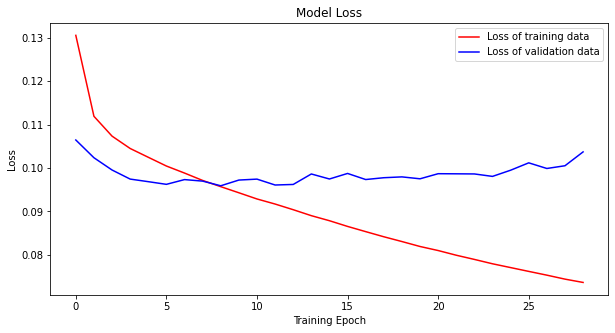

In [18]:
loss = history.history['loss']
val_loss = history.history['val_loss']
min_loss = min(val_loss)
print(f'Minimal Loss: {min_loss*max_throughput:.4f}')
plt.figure(figsize=(10,5))
plt.plot(loss, 'r', label='Loss of training data')
plt.plot(val_loss, 'b-', label='Loss of validation data')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Training Epoch')
plt.legend()
plt.show()

Minimal MAE 184.1 Mbps
Minimal RMSE 287.0 Mbps


<Figure size 432x288 with 0 Axes>

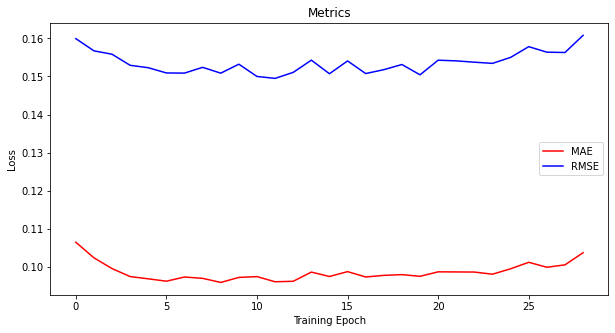

In [19]:
# RMSE and MAE plots
plt.clf() # clear the figure
mae = history.history['val_mean_absolute_error']
min_mae = min(mae)
print(f'Minimal MAE {min_mae*max_throughput:.1f} Mbps')
rmse = history.history['val_root_mean_squared_error']
min_rmse = min(rmse)
print(f'Minimal RMSE {min_rmse*max_throughput:.1f} Mbps')
plt.figure(figsize=(10,5))
plt.plot(mae, 'r', label='MAE')
plt.plot(rmse, 'b', label='RMSE')
plt.title('Metrics')
plt.ylabel('Loss')
plt.xlabel('Training Epoch')
plt.legend()
plt.show()

## 5. Test-Prediction Comparision

Forecast MSE of the example: 0.0114


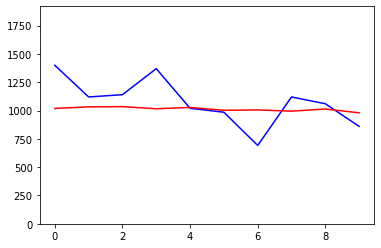

In [20]:
n = 30 # test example number
x_in = X_test[n].reshape(1, seconds_in, n_features)
y_true = y_test[n] # test true
y_pred = model.predict(x_in).flatten()
plt.plot(y_true * max_throughput, 'b')
plt.plot(y_pred * max_throughput, 'r')
plt.ylim(0, max_throughput)
print(f'Forecast MSE of the example: {mean_squared_error(y_true, y_pred):.4f}')
plt.show()

## 6. Plotting Multiple Examples

<Figure size 432x288 with 0 Axes>

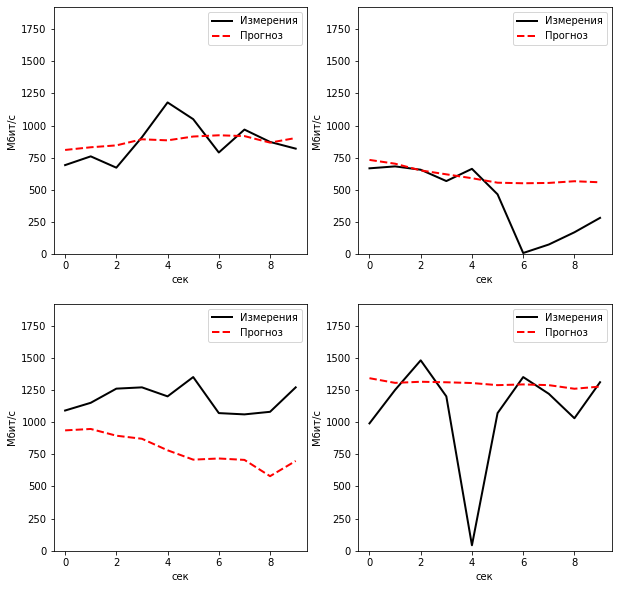

In [51]:
plt.clf() # clear the figure
numbers = [50, 150, 180, 330] # numbers of examples
c = 1 # initial subplot number
fig = plt.figure(figsize=(10, 10)) # size
for n in numbers:
    plt.subplot(2, 2, c) # 2X2 subplot
    x_in = X_test[n].reshape(1, seconds_in, n_features)
    y_true = y_test[n] # test true
    y_pred = model.predict(x_in).flatten()
    plt.plot(y_true * max_throughput, 'k', linewidth=2, linestyle='solid', label='Измерения')
    plt.plot(y_pred * max_throughput, 'r', linewidth=2, linestyle='dashed', label='Прогноз')
    plt.ylim(0, max_throughput)
    plt.ylabel('Мбит/c')
    plt.xlabel('сек')
    plt.legend()
    c = c + 1 # next subplot number
plt.savefig('CNN_Examples.png')
plt.show()